2024-09-08 16:31:01.325003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-08 16:31:01.342623: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-08 16:31:01.342659: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-08 16:31:01.355469: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-08 16:31:02.078038: W tensorflow/compiler/tf

Training dataset loaded completely


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 137.65it/s]


Validation dataset loaded completely
Total images :  118
Total masks :  118


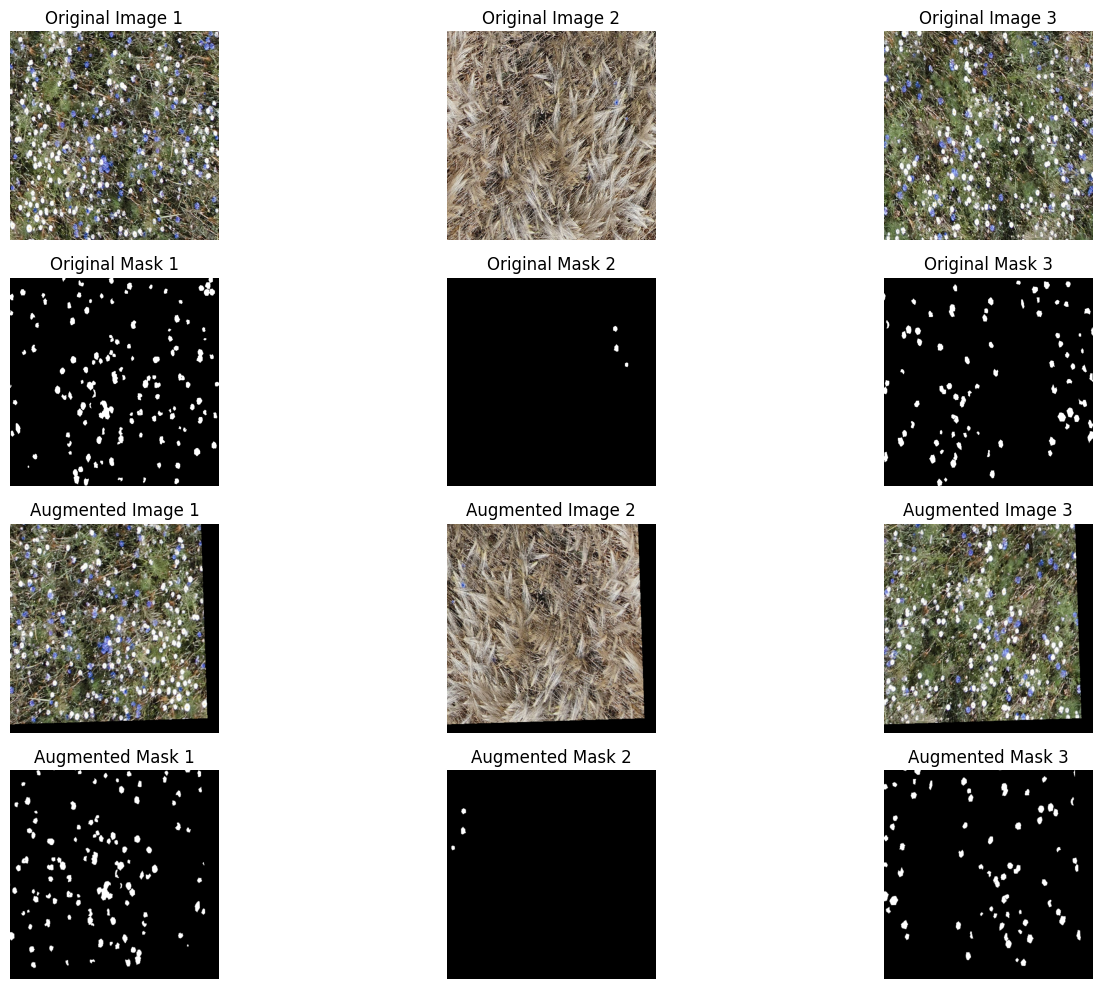

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 156.78it/s]


Training dataset loaded completely


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 161.67it/s]

Validation dataset loaded completely


In [1]:
import os
import cv2
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Reshape, UpSampling2D, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define image dimensions and channels
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 3
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
num_classes = 1  # Single class segmentation
SEED = 40

train_image_dir = '/home/syam.varnatt/THESIS/images/train/images'
train_mask_dir = '/home/syam.varnatt/THESIS/images/train/masks'
val_image_dir = '/home/syam.varnatt/THESIS/images/val/images'
val_mask_dir = '/home/syam.varnatt/THESIS/images/val/masks'
SAVE_DIRECTORY = '/home/syam.varnatt/THESIS/comparison-model/segnet/aug/results'

def load_dataset(image_dir, mask_dir, img_size):
    images = []
    masks = []
    
    for image_name in tqdm(os.listdir(image_dir)):
        if image_name.lower().endswith(('.jpeg', '.jpg')):
            base_name = os.path.splitext(image_name)[0]
            mask_name = f"{base_name}_mask.jpg"
            
            img_path = os.path.join(image_dir, image_name)
            mask_path = os.path.join(mask_dir, mask_name)
            
            if os.path.exists(img_path) and os.path.exists(mask_path):
                try:
                    image = load_img(img_path, target_size=img_size)
                    mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")
                    
                    image = img_to_array(image)
                    mask = img_to_array(mask)
                    
                    images.append(image)
                    masks.append(mask)
                except Exception as e:
                    print(f"Error processing {image_name}: {e}")
            else:
                print(f"Mask not found for image: {image_name}")
    
    images = np.array(images) / 255.0
    masks = np.array(masks) / 255.0
    masks = (masks > 0.5).astype(np.uint8)
    
    return images, masks

def display_images_and_masks(original_images, original_masks, augmented_images, augmented_masks, num=3):
    """Display original and augmented images and masks in a grid layout."""
    plt.figure(figsize=(15, 10))
    for i in range(num):
        # Display original images
        plt.subplot(4, num, i + 1)
        plt.imshow(original_images[i])
        plt.title(f'Original Image {i+1}')
        plt.axis('off')

        plt.subplot(4, num, i + 1 + num)
        plt.imshow(original_masks[i].squeeze(), cmap='gray')
        plt.title(f'Original Mask {i+1}')
        plt.axis('off')

        # Display augmented images
        plt.subplot(4, num, i + 1 + num*2)
        plt.imshow(augmented_images[i])
        plt.title(f'Augmented Image {i+1}')
        plt.axis('off')

        plt.subplot(4, num, i + 1 + num*3)
        plt.imshow(augmented_masks[i].squeeze(), cmap='gray')
        plt.title(f'Augmented Mask {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Data augmentation setup
data_gen_args = dict(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0,
    rescale=1.0
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Load datasets
train_images, train_masks = load_dataset(train_image_dir, train_mask_dir, (IMG_HEIGHT, IMG_WIDTH))
print("Training dataset loaded completely")
val_images, val_masks = load_dataset(val_image_dir, val_mask_dir, (IMG_HEIGHT, IMG_WIDTH))
print("Validation dataset loaded completely")

# Ensure the same seed is used for images and masks
image_datagen.fit(train_images, augment=True, seed=SEED)
mask_datagen.fit(train_masks, augment=True, seed=SEED)

# Generate augmented images and masks
augmented_images, augmented_masks = [], []
for i in range(len(train_images)):
    img = train_images[i].reshape((1,) + train_images[i].shape)
    mask = train_masks[i].reshape((1,) + train_masks[i].shape)
    
    img_gen = image_datagen.flow(img, batch_size=1, seed=SEED)
    mask_gen = mask_datagen.flow(mask, batch_size=1, seed=SEED)
    
    augmented_images.append(img_gen[0][0])
    augmented_masks.append(mask_gen[0][0])

augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

# Concatenate the original and augmented datasets
all_images = np.concatenate((train_images, augmented_images), axis=0)
all_masks = np.concatenate((train_masks, augmented_masks), axis=0)

total_images = len(all_images)
total_masks = len(all_masks)

print("Total images : ", total_images)
print("Total masks : ", total_masks)
# Display images and masks before and after augmentation
display_images_and_masks(train_images, train_masks, augmented_images, augmented_masks)

# Load datasets
train_images, train_masks = load_dataset(train_image_dir, train_mask_dir, (IMG_HEIGHT, IMG_WIDTH))
print("Training dataset loaded completely")
val_images, val_masks = load_dataset(val_image_dir, val_mask_dir, (IMG_HEIGHT, IMG_WIDTH))
print("Validation dataset loaded completely")

In [ ]:
def build_segnet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(up1)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)

    up2 = UpSampling2D(size=(2, 2))(conv4)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

    up3 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3)
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(conv6)

    model = Model(inputs=inputs, outputs=outputs)
    return model

#compile the SegNet model
model = build_segnet()
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2024-09-08 16:31:09.151762: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-08 16:31:09.192844: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-08 16:31:09.194703: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 512, 512, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 512, 512, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 128, 128, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 128)  │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 256, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 256, 256, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 256, 256, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 512, 512, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 512, 512, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 512, 512, 1)    │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,469,057 (13.23 MB)

 Trainable params: 3,469,057 (13.23 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
class VisualizationCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_images, val_masks, save_dir, num_samples=3):
        super(VisualizationCallback, self).__init__()
        self.val_images = val_images
        self.val_masks = val_masks
        self.save_dir = save_dir
        self.num_samples = num_samples  # Number of samples to visualize per epoch
        os.makedirs(save_dir, exist_ok=True)  # Ensure the save directory exists

    def on_epoch_end(self, epoch, logs=None):
        # Randomly select a few samples to visualize predictions
        idxs = np.random.choice(len(self.val_images), self.num_samples, replace=False)
        images_to_show = self.val_images[idxs]
        masks_to_show = self.val_masks[idxs]
        
        # Use the model attribute directly, which is set automatically by Keras
        predictions = self.model.predict(images_to_show)

        # Plot and save the images, masks, and predictions
        plt.figure(figsize=(15, 10))
        for i in range(self.num_samples):
            plt.subplot(self.num_samples, 3, i * 3 + 1)
            plt.imshow(images_to_show[i])
            plt.title(f'Input Image {i+1}')
            plt.axis('off')

            plt.subplot(self.num_samples, 3, i * 3 + 2)
            plt.imshow(masks_to_show[i].squeeze(), cmap='gray')
            plt.title(f'True Mask {i+1}')
            plt.axis('off')

            plt.subplot(self.num_samples, 3, i * 3 + 3)
            plt.imshow(predictions[i].squeeze(), cmap='gray')
            plt.title(f'Predicted Mask {i+1}')
            plt.axis('off')

        plt.tight_layout()
        # Save the plot to file
        plt.savefig(os.path.join(self.save_dir, f'epoch_{epoch+1:02d}_predictions.png'))
        plt.close()
        print(f"Saved visualization for epoch {epoch+1}.")

# Instantiate the visualization callback
visualization_callback = VisualizationCallback(val_images, val_masks, SAVE_DIRECTORY)


In [4]:
class TrainingTimeCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        end_time = time.time()
        training_time = end_time - self.start_time
        print(f"Training Time: {training_time / 60:.2f} minutes")

# Create an instance of the callback
training_time_callback = TrainingTimeCallback()

# Define callbacks
checkpoint = ModelCheckpoint('segnet_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

# Train the model
history = model.fit(
    all_images, all_masks,
    validation_data=(val_images, val_masks),
    batch_size=8,
    epochs=100,
    callbacks=[checkpoint, early_stopping, training_time_callback, visualization_callback]
)

# Save the training history to an Excel file
history_df = pd.DataFrame(history.history)
history_df.to_excel(os.path.join('training_history.xlsx'), index=False)

Epoch 1/100


I0000 00:00:1725805898.911730 1330561 service.cc:145] XLA service 0x7dd810045830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725805898.911778 1330561 service.cc:153]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-09-08 16:31:38.997843: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-08 16:31:39.302351: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 2/15 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.9676 - loss: 0.6296 

I0000 00:00:1725805919.467279 1330561 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9668 - loss: 0.5860

2024-09-08 16:32:03.033177: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 33.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-08 16:32:13.294167: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 32.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9672 - loss: 0.5757  

2024-09-08 16:32:18.695554: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 33.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.



Epoch 1: val_loss improved from inf to 0.15754, saving model to segnet_model.keras


2024-09-08 16:32:21.192896: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 32.65GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Saved visualization for epoch 1.
15/15 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9674 - loss: 0.5666 - val_accuracy: 0.9816 - val_loss: 0.1575
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9698 - loss: 0.1727
Epoch 2: val_loss improved from 0.15754 to 0.11847, saving model to segnet_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Saved visualization for epoch 2.
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.9699 - loss: 0.1712 - val_accuracy: 0.9816 - val_loss: 0.1185
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9706 - loss: 0.1449
Epoch 3: val_loss improved from 0.11847 to 0.09146, saving model to segnet_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Saved visualization for epoch 3.
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.9706 - loss: 0.1437 - val_accuracy: 0.9816 - val_loss: 0.0915
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9713 - loss: 0.1122
Epoch 4:

2024-09-08 16:37:18.137027: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 34.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Precision:  0.820347548781147 F1 score:  0.8298397293510577 Mean Iou :  0.8513683


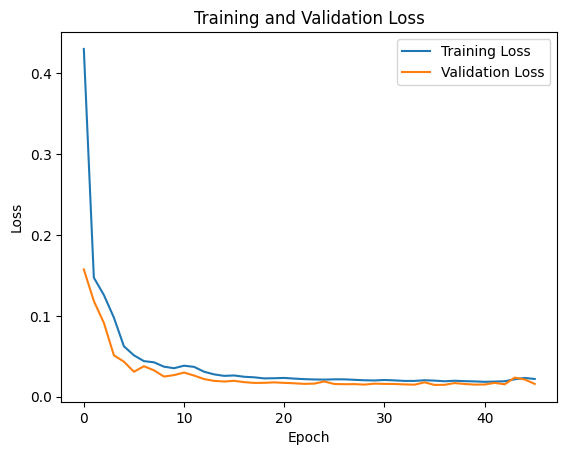

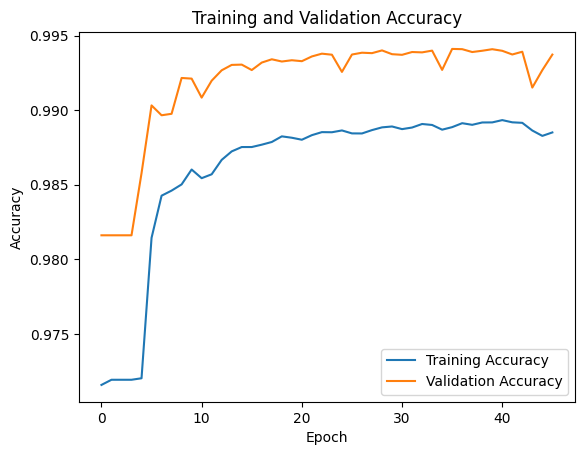

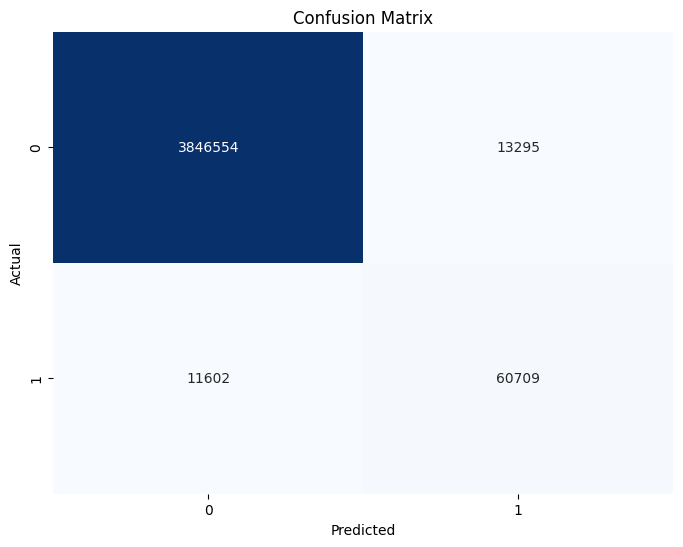

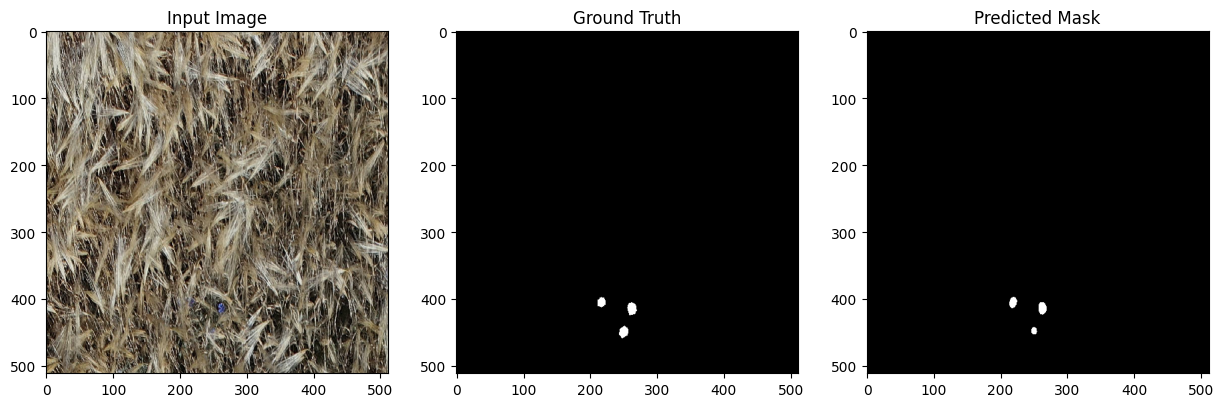

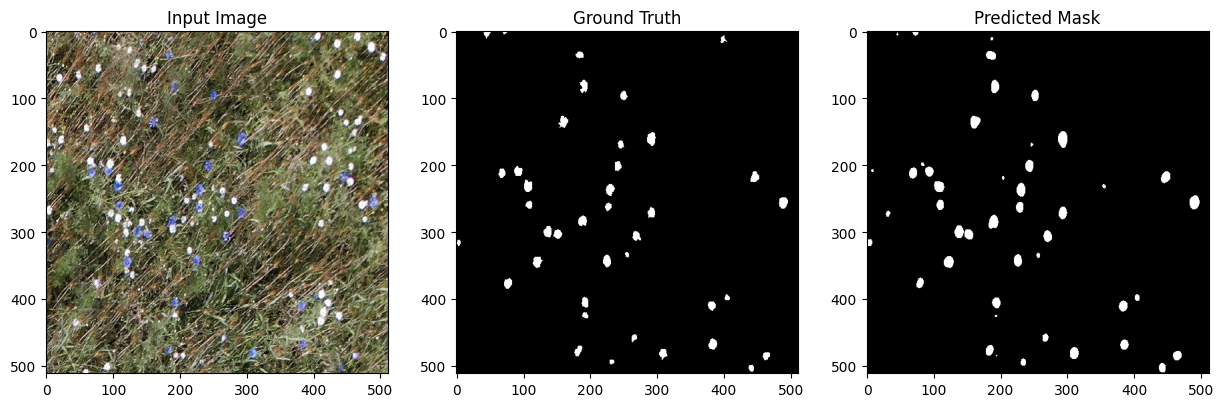

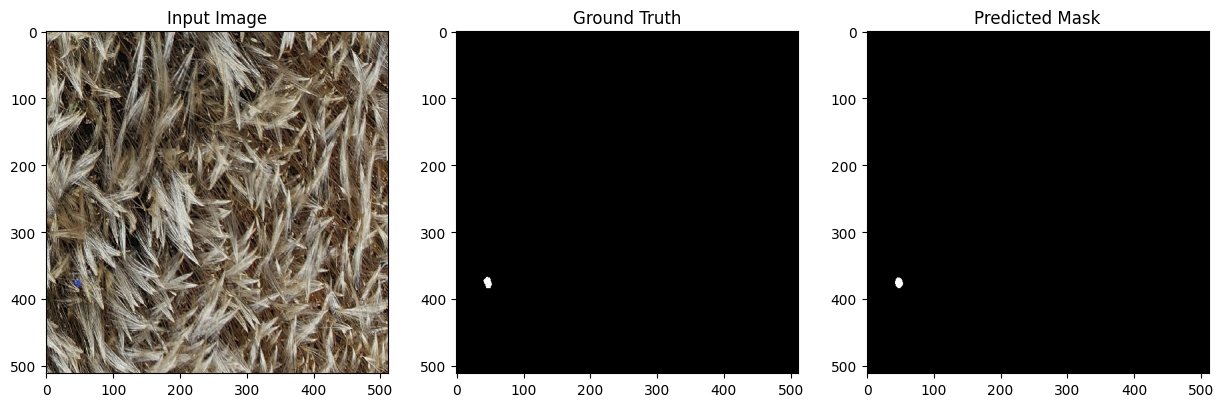

In [5]:

# Predict on validation set
val_preds = model.predict(val_images)

# Convert predictions to binary
val_preds_bin = (val_preds > 0.3).astype(int)

# Calculate additional metrics
precision = precision_score(val_masks.flatten(), val_preds_bin.flatten())
f1 = f1_score(val_masks.flatten(), val_preds_bin.flatten())

# Calculate Mean IoU
mean_iou_metric = tf.keras.metrics.MeanIoU(num_classes=2) 
mean_iou_metric.update_state(val_masks, val_preds_bin)
mean_iou = mean_iou_metric.result().numpy()

# Save metrics to Excel
metrics_df = pd.DataFrame({
    'Precision': [precision],
    'F1 Score': [f1],
    'Mean IoU': [mean_iou]
})
print(f"Precision: ", precision, "F1 score: ", f1, "Mean Iou : ", mean_iou)

# Plot training history
history_df = pd.read_excel('training_history.xlsx')

plt.figure()
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

plt.figure()
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_plot.png')
plt.show()

# Save confusion matrix as heatmap
cm = confusion_matrix(val_masks.flatten(), val_preds_bin.flatten())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Visualize some predictions on validation set
for i in range(3):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(val_images[i])
    axs[0].set_title('Input Image')
    axs[1].imshow(val_masks[i].squeeze(), cmap='gray')
    axs[1].set_title('Ground Truth')
    axs[2].imshow(val_preds_bin[i].squeeze(), cmap='gray')
    axs[2].set_title('Predicted Mask')
    plt.savefig(f'prediction_{i}.png')
    plt.show()

In [6]:
#calculate inference time

# Use a small batch from validation data
sample_images = val_images[:5]

# Measure inference time
start_time = time.time()
predictions = model.predict(sample_images)
end_time = time.time()

inference_time = (end_time - start_time) / len(sample_images)
print(f"Average Inference Time per Image: {inference_time:.4f} seconds")

2024-09-08 16:37:57.668635: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 32.90GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Average Inference Time per Image: 0.4646 seconds


In [7]:

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.models import load_model

# Define input size
input_size = (512, 512, 3)

# Function to preprocess images
def preprocess_image(image_path, target_size):
    # Load image
    image = load_img(image_path, target_size=target_size[:2])
    # Convert to numpy array
    image_array = img_to_array(image)
    # Normalize the image
    image_array = image_array / 255.0
    return image_array

# Function to save images
def save_image(image_array, save_path):
    # Convert array to image
    image = array_to_img(image_array)
    # Save the image
    image.save(save_path)

# Function to display images
def display_images(images, titles=None, cmap='gray'):
    plt.figure(figsize=(20, 10))
    for i, image in enumerate(images):
        plt.subplot(3, 4, i + 1)  # Adjust depending on the number of images
        plt.imshow(image, cmap=cmap)
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Load and preprocess images
image_folder = '/home/syam.varnatt/THESIS/Plot_Images(x10,x20)'
image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith('.png')]

# Sort the image paths by filenames
image_paths = sorted(image_paths)

# Select a subset of images
image_paths = image_paths[0:]

# Predict segmentation masks for each image
# Extract image names from paths
image_names = [os.path.basename(path) for path in image_paths]

# Define the folder path to save images and masks
save_folder = '/home/syam.varnatt/THESIS/comparison-model/segnet/aug/predict_height'
os.makedirs(save_folder, exist_ok=True)

# Predict segmentation masks and save images and masks
predicted_masks = []
for i, image_path in enumerate(image_paths):
    # Preprocess image
    image = preprocess_image(image_path, input_size)
    image_batch = np.expand_dims(image, axis=0)
    # Predict mask
    predicted_mask = model.predict(image_batch)[0]
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
    
    # Save the original image
    original_image = img_to_array(load_img(image_path, target_size=input_size[:2])) / 255.0
    save_image(original_image, os.path.join(save_folder, f'original_{image_names[i]}'))
    
    # Save the predicted mask
    save_image(predicted_mask, os.path.join(save_folder, f'mask_{image_names[i]}'))
    
    predicted_masks.append(predicted_mask)


2024-09-08 16:39:47.340207: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 32.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━

In [9]:
#calculate inference time for predicting heights

# Use a small batch from validation data
sample_images = image_batch[:5]

# Measure inference time
start_time = time.time()
predictions = model.predict(sample_images)
end_time = time.time()

inference_time = (end_time - start_time) / len(sample_images)
print(f"Average Inference Time per flight height predicted Image: {inference_time:.4f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Average Inference Time per flight height predicted Image: 0.0578 seconds
